In this notebook we're going to make a demonstration on how to request the repository from github, download the data from kaggle and train the generator.

In [1]:
!git clone https://github.com/TheMagicShop/Wasserstein-GAN-for-Anime-Face-Generation.git
%cd Wasserstein-GAN-for-Anime-Face-Generation
# training is below

Cloning into 'Wasserstein-GAN-for-Anime-Face-Generation'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 58 (delta 23), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (58/58), done.
/content/Wasserstein-GAN-for-Anime-Face-Generation


In [2]:
# to download data directly from the kaggle API
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d soumikrakshit/anime-faces
!unzip -qq anime-faces.zip

 99% 436M/441M [00:02<00:00, 176MB/s]
100% 441M/441M [00:02<00:00, 182MB/s]


In [3]:
import os, shutil

source = 'data'
shutil.rmtree('data/data') # there is an unwanted file inside, we remove it 
n_images = len(os.listdir(source)) # number of images found
print(f'We have {n_images} anime faces in the dataset')

We have 21551 anime faces in the dataset


saving random_anime_faces.png in ./figures ...


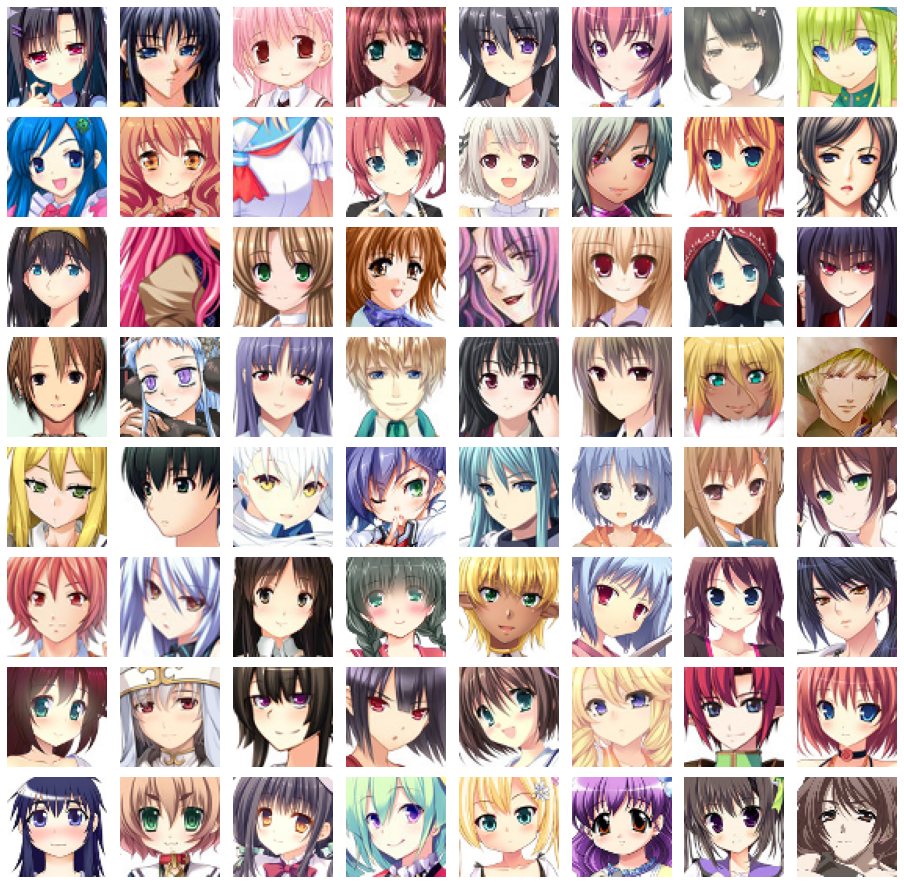

In [4]:
import matplotlib.pyplot as plt
from utils import DataPreparator # utils is a pre-hand-built library
from utils import save_figure

n_rows, n_cols = 8, 8
fig, axes = plt.subplots(n_rows, n_cols, 
                         figsize=(2*n_cols, 2*n_rows))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

data_preparator = DataPreparator(source, None) # fit the source and flow directly from it
imgs = data_preparator.prepare_real_batch()
for i, ax in enumerate(axes.ravel()):
  ax.imshow(imgs[i])
  ax.set_axis_off()

save_figure('random_anime_faces')

saving anime_mean_face.png in ./figures ...


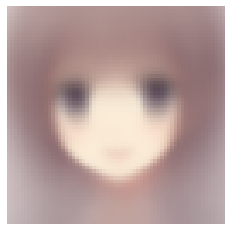

In [5]:
import numpy as np

# plot the mean of all images -the pixels average-
size = (64, 64)
mean_face = np.zeros(size + (3, ))

data_preparator.reset_index()
n = data_preparator.steps_per_epoch
for _ in range(n):
  imgs = data_preparator.prepare_real_batch()
  mean_face += imgs.mean(axis=0)
mean_face = mean_face / n

plt.imshow(mean_face)
plt.axis('off')
save_figure('anime_mean_face')

the mean image insures us that the data is consistent, because the hair,  the eyes and -to a lesser scale- the mouth, are remarkably in their places, and are sharply noticeable.

In [6]:
!python train_generator.py --source 'data' --shape 64 64 --batch_size 64 --noise_dim 100 --train_steps 20000

Building the generator...
2022-10-05 22:36:41.848472: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Building the discriminator...
Building the adversarial...
plotting model architectures on figures/ ...
step: 0, disc_loss: 0.013, adv_loss: -0.000
step: 1, disc_loss: 0.000, adv_loss: -0.000
step: 2, disc_loss: 0.000, adv_loss: -0.001
step: 3, disc_loss: -0.000, adv_loss: -0.001
step: 4, disc_loss: -0.000, adv_loss: -0.001
step: 5, disc_loss: -0.000, adv_loss: -0.001
step: 6, disc_loss: -0.000, adv_loss: -0.001
step: 7, disc_loss: -0.000, adv_loss: -0.001
step: 8, disc_loss: -0.000, adv_loss: -0.002
step: 9, disc_loss: -0.001, adv_loss: -0.002
step: 10, disc_loss: -0.001, adv_loss: -0.003
step: 11, disc_loss: -0.001, adv_loss: -0.003
step: 12, disc_loss: -0.002, adv_loss: -0.004
step: 13, disc_loss: -0.002, adv_loss: -0.005
step: 14, disc_loss: -

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

noise_dim = 100
path = './params/generator.h5'
generator = load_model(path)

random_vector = np.random.uniform(low=-1,
                                  high=1,
                                  size=(noise_dim, ))
# in this experiment we want to cover all first and last axes possibilities,
# while retaining the middle components intact, to see what's going to change in the image
# so we need to iterate first and last components over [-1,1]x[-1,1] (double iteration)
# without the need to use for loops, here is an elegant way
# first, put the components of interest at 1
random_vector[0], random_vector[-1] = 1, 1
# then use this trick
x, y = np.linspace(-1, 1, 11), np.linspace(-1, 1, 11)
xx, yy = np.meshgrid(x, y)
xx, yy = xx.ravel(), yy.ravel()
# yy = [-1, -1, ..,-1, -0.8, -0.8, .., ..., 1, 1]
# xx = [-1, -0.8, -0.6, .., 1, -1, -0.8, .., ... ,0.8 , 1]
xx = xx[:, np.newaxis]
yy = yy[:, np.newaxis]
mm = np.ones((len(xx), noise_dim-2))
Z = np.hstack([yy, mm, xx])
# y-axis correspond to 1st component
# x-axis correspond to last component
grid_vectors = Z * random_vector
grid = generator.predict(grid_vectors) # (121, 64, 64, 3)
grid = np.reshape(grid, (11, 11, ) + grid.shape[1:])
# to be continued


In [ ]:

# morphing
random_v1, random_v2 = np.random.uniform(low=-1,
                                         high=1,
                                         size=(noise_dim, 2))
img1, img2 = generator.predict([random_v1, random_v2])

figure = plt.figure(figsize=(8, 4))
plt.imshow(np.hstack(img1, img2))
plt.axis('off')
plt.show()

# varying alpha from 0.1 to 0.9 with a step of 0.1
# for alpha=0/alpha=1, it's just first/second image respectively
alpha = np.arange(0.1, 1, 0.1)
alpha = alpha[:, np.newaxis]
morphed_vectors = img1 * (1 - alpha) + img2 * alpha
morphed_imgs = generator.predict(morphed_vectors)
morphed_imgs = morphed_imgs.reshape((3, 3, ) + morphed_imgs.shape[2:])
figure = plt.figure(figsize=(12, 12))
plt.imshow(morphed_imgs)
plt.axis('off')
plt.show()
